This is Python code of part 3.1 in undergradution thesis.

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import read_csv, concat
from dateutil.parser import parse
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product
from tqdm.notebook import tqdm  
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.model_selection import ParameterGrid
import matplotlib.patches as mpatches
from statsmodels.tsa.seasonal import seasonal_decompose

# 配置 Matplotlib 正常显示中文标签和负号 Configure Matplotlib to display Chinese labels and negative signs
plt.rcParams['font.sans-serif'] = ['SimHei']  # display Chinese labels properly
plt.rcParams['axes.unicode_minus'] = False    # display the minus sign normally

In [2]:
# 读取新能源汽车数据 Load data
df_nev_sale = pd.read_excel('E:\\qjy\\ecnu\\毕业论文\\新能源汽车数据\\中国-新能源汽车数据-已处理\\中国新能源汽车销量-已处理.xlsx', index_col=0)
df_nev_sale.head()

,nev_sale
date,
2014-01-01,2640
2014-02-01,2169
2014-03-01,2538
2014-04-01,2540
2014-05-01,2754


In [3]:
# 统计缺失值  Count missing value
missing_values = df_nev_sale['nev_sale'].isnull().sum()
print(f'Number of missing values: {missing_values}')

Number of missing values: 0


In [4]:
# Set date index
df_nev_sale.index = pd.date_range('2014-01-01', '2024-01-01', freq='M')
df_nev_sale = df_nev_sale[24:]

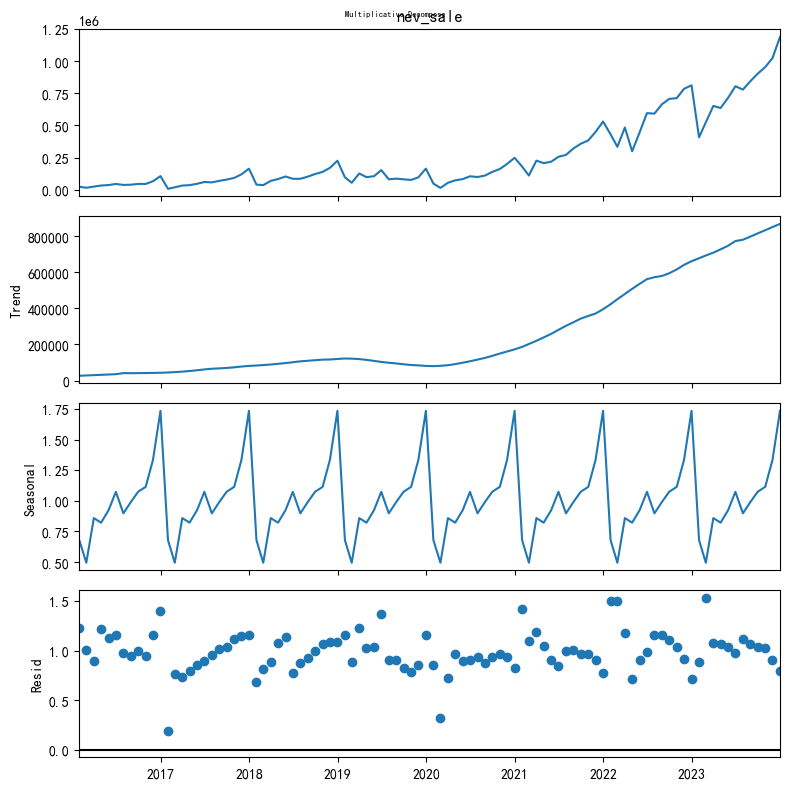

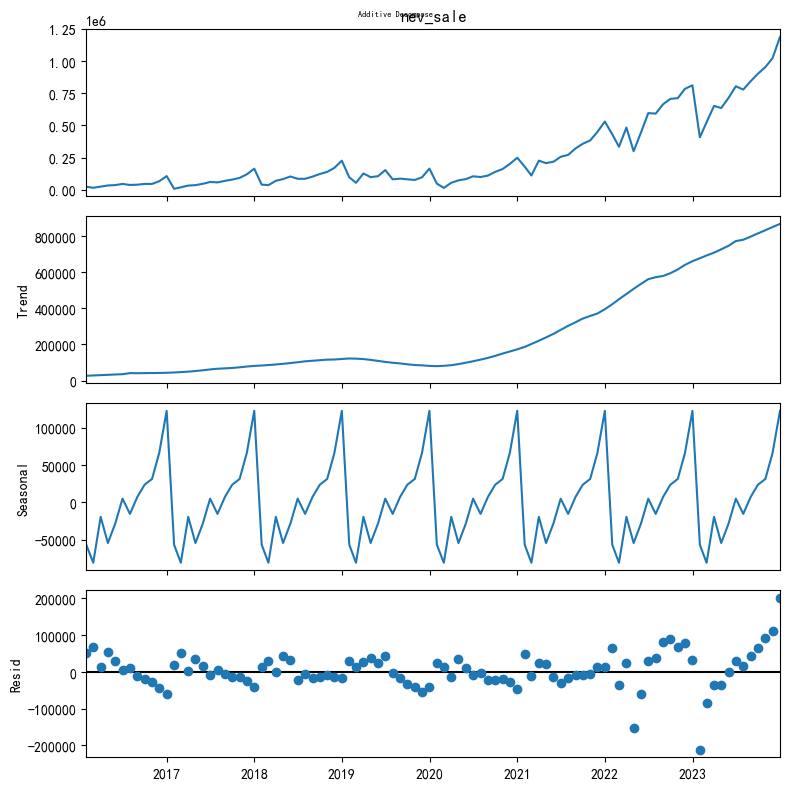

In [6]:
# Multiplicative and Additive Decomposition
# The residuals in the additive decomposition show some leftover patterns, whereas the residuals in the multiplicative decomposition show no trend. Therefore, multiplicative decomposition should be preferred for this specific time series.

# Multiplicative Decomposition
result_mul = seasonal_decompose(df_nev_sale['nev_sale'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_nev_sale['nev_sale'], model='additive', extrapolate_trend='freq')

# Plotting
plt.rcParams.update({'figure.figsize': (8, 8)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=6)
result_add.plot().suptitle('Additive Decompose', fontsize=6)
plt.show()


In [7]:
# Split the dataset into training and test sets
df_nev_sale_train = df_nev_sale.loc['2016-01-01':'2022-12-31', ['nev_sale']]
# Split the test set
df_nev_sale_test = df_nev_sale.loc['2022-01-31':, ['nev_sale']]


In [8]:
# Stationarity test: the original data is non-stationary
# ADF Test (Augmented Dickey-Fuller Test)
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_nev_sale_train['nev_sale'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')


ADF Statistic: 1.140520104329296
p-value: 0.9955480318056941
Critical Values:
1%: -3.526004646825607
5%: -2.9032002348069774
10%: -2.5889948363419957


In [9]:
# The data becomes stationary after first-order differencing and seasonal differencing
# First-order differencing
df_nev_sale_train['nev_sale_diff1'] = df_nev_sale_train['nev_sale'].diff()
df_nev_sale_train.dropna(axis=0, how='any', inplace=True)

# Seasonal differencing (with a 12-month period)
df_nev_sale_train['nev_sale_diff1_diff12'] = df_nev_sale_train['nev_sale_diff1'].diff(12)
df_nev_sale_train.dropna(axis=0, how='any', inplace=True)

# Perform the ADF Test again
result = adfuller(df_nev_sale_train['nev_sale_diff1_diff12'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')


ADF Statistic: -11.060209232304675
p-value: 4.8307177094259025e-20
Critical Values:
1%: -3.5274258688046647
5%: -2.903810816326531
10%: -2.5893204081632653


In [10]:
# White noise test
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test for autocorrelation (White noise test)
print('The result of the white noise test for the transformed first-order differenced and 12-step differenced series is:\n', acorr_ljungbox(df_nev_sale_train['nev_sale_diff1_diff12'].values, lags=12))


The result of the white noise test for the transformed first-order differenced and 12-step differenced series is:
       lb_stat  lb_pvalue
1    6.262691   0.012331
2    6.399809   0.040766
3    8.757380   0.032697
4   12.093598   0.016669
5   12.093626   0.033527
6   12.652617   0.048896
7   13.651533   0.057738
8   14.842534   0.062281
9   14.866279   0.094675
10  15.025430   0.131137
11  15.701184   0.152592
12  16.227697   0.181028


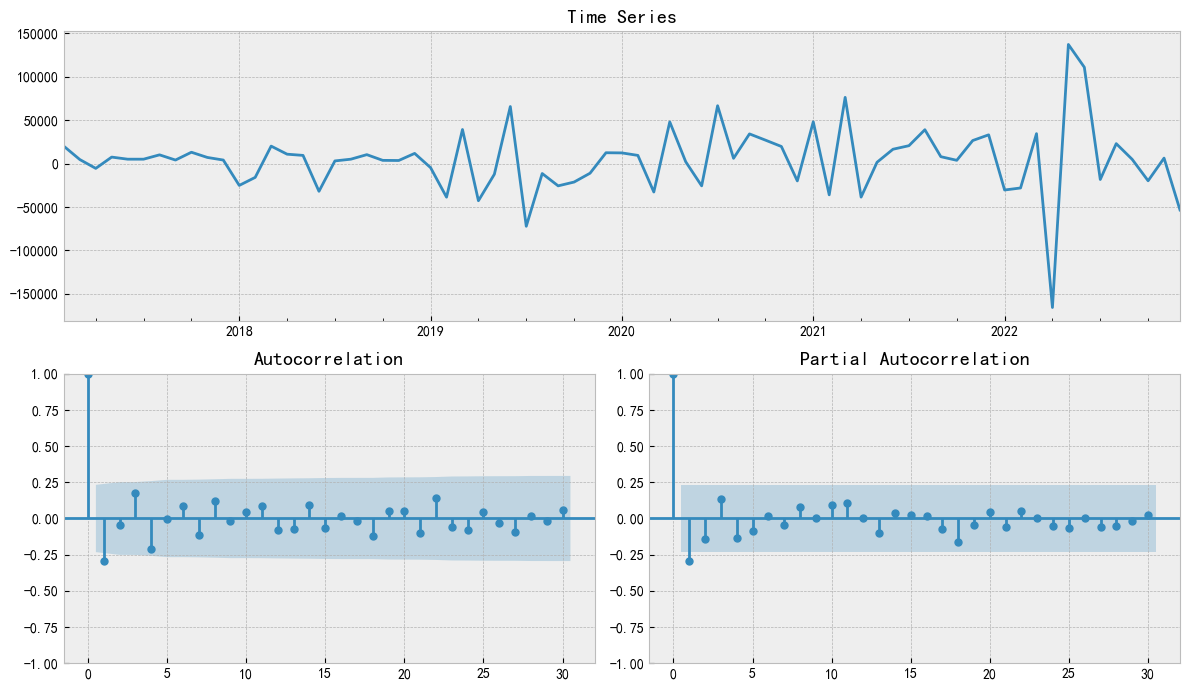

ADF Statistic: -11.060209232304675
p-value: 4.8307177094259025e-20
Critical Values:
1%: -3.5274258688046647
5%: -2.903810816326531
10%: -2.5893204081632653


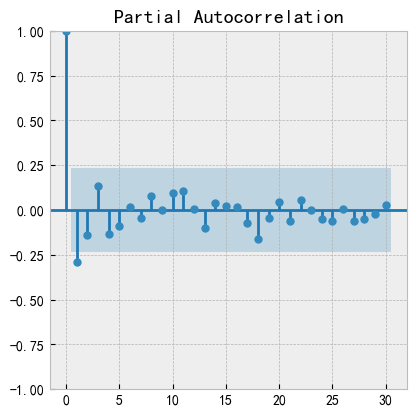

In [11]:
# MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Visualization function for time series plot, ACF, PACF, and Dickey-Fuller test
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    Plot time series, ACF, PACF, and perform the Dickey–Fuller test
    y - time series
    lags - number of lags for ACF and PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.show()

        # Perform ADF test and print the results
        result = adfuller(y.values, autolag='AIC')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'{key}: {value}')
        # Continue plotting with pacf_ax
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        # Plot time series
        y.plot(ax=ts_ax)
        p_value = adfuller(y.values, autolag='AIC')[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))

        # Plot ACF and PACF
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

# Visualize using the tsplot function
tsplot(df_nev_sale_train['nev_sale_diff1_diff12'], lags=30)


In [12]:
# ARIMA parameter settings
ps = range(0, 2)
d = range(1, 2)
qs = range(0, 2)

# Seasonal-related parameter settings
Ps = range(0, 2)
D = range(1, 2)
Qs = range(0, 2)

# Pack the parameters and use the BIC criterion for parameter selection
params_list = list(product(ps, d, qs, Ps, D, Qs))
print(params_list)


[(0, 1, 0, 0, 1, 0), (0, 1, 0, 0, 1, 1), (0, 1, 0, 1, 1, 0), (0, 1, 0, 1, 1, 1), (0, 1, 1, 0, 1, 0), (0, 1, 1, 0, 1, 1), (0, 1, 1, 1, 1, 0), (0, 1, 1, 1, 1, 1), (1, 1, 0, 0, 1, 0), (1, 1, 0, 0, 1, 1), (1, 1, 0, 1, 1, 0), (1, 1, 0, 1, 1, 1), (1, 1, 1, 0, 1, 0), (1, 1, 1, 0, 1, 1), (1, 1, 1, 1, 1, 0), (1, 1, 1, 1, 1, 1)]


In [13]:
# Find the best parameters based on AIC
def find_best_params(data: np.array, params_list):
    result = []
    best_aic = 100000  # Initialize AIC value
    best_model = None
    best_param = None
    
    for param in tqdm(params_list):  # tqdm_notebook is deprecated, use tqdm.notebook instead
        # Fit SARIMA model
        try:
            model = SARIMAX(data, order=(param[0], param[1], param[2]),
                            seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
            aicc = model.aic  # Get the AIC value of the model

            # Find the best model
            if aicc < best_aic:
                best_model = model
                best_aic = aicc
                best_param = param
                param_1 = (param[0], param[1], param[2])
                param_2 = (param[3], param[4], param[5], 12)
                param_str = 'SARIMA{0}x{1}'.format(param_1, param_2)
                print(param_str)

            result.append([param_str, model.aic])

        except Exception as e:
            print(f"Error for parameters {param}: {e}")
            continue

    result_table = pd.DataFrame(result)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    return result_table

# Split the training set
df_train = df_nev_sale.loc['2016-01-31':'2022-12-31', ['nev_sale']]

# Find the best parameter combination
result_table = find_best_params(df_train['nev_sale'].values, params_list)
print(result_table)


  0%|          | 0/16 [00:00<?, ?it/s]

SARIMA(0, 1, 0)x(0, 1, 0, 12)
SARIMA(0, 1, 1)x(0, 1, 0, 12)
                       parameters          aic
0   SARIMA(0, 1, 1)x(0, 1, 0, 12)  1702.911312
1   SARIMA(0, 1, 1)x(0, 1, 0, 12)  1703.299942
2   SARIMA(0, 1, 1)x(0, 1, 0, 12)  1704.860667
3   SARIMA(0, 1, 1)x(0, 1, 0, 12)  1704.867513
4   SARIMA(0, 1, 1)x(0, 1, 0, 12)  1704.870771
5   SARIMA(0, 1, 1)x(0, 1, 0, 12)  1705.168587
6   SARIMA(0, 1, 1)x(0, 1, 0, 12)  1705.194666
7   SARIMA(0, 1, 1)x(0, 1, 0, 12)  1705.195938
8   SARIMA(0, 1, 1)x(0, 1, 0, 12)  1705.348264
9   SARIMA(0, 1, 1)x(0, 1, 0, 12)  1706.806500
10  SARIMA(0, 1, 1)x(0, 1, 0, 12)  1706.818871
11  SARIMA(0, 1, 1)x(0, 1, 0, 12)  1707.147652
12  SARIMA(0, 1, 0)x(0, 1, 0, 12)  1708.236053
13  SARIMA(0, 1, 0)x(0, 1, 0, 12)  1709.905836
14  SARIMA(0, 1, 0)x(0, 1, 0, 12)  1715.341747
15  SARIMA(0, 1, 0)x(0, 1, 0, 12)  1716.983457


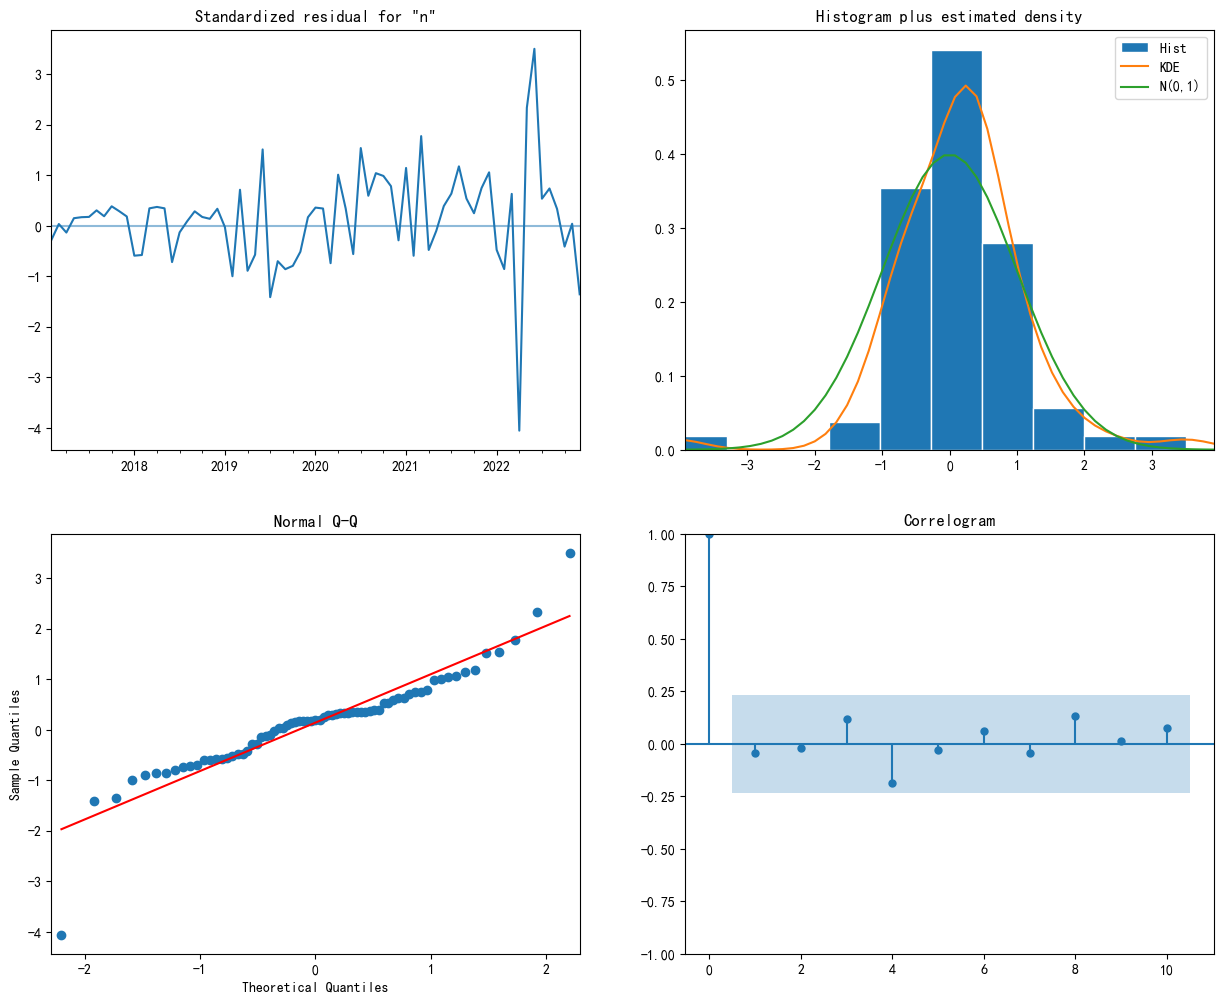

In [14]:
# Fit the model using SARIMAX
# SARIMAX(0, 1, 1)x(0, 1, 0, 12)
ma = SARIMAX(df_train, order=(0, 1, 1), seasonal_order=(0, 1, 0, 12)).fit(disp=-1)

# Get residuals and plot diagnostics
resid = ma.resid
fig = ma.plot_diagnostics(figsize=(15, 12))
plt.show()


In [15]:
# SRIMA model summary
ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            nev_sale   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -849.456
Date:                             Tue, 08 Oct 2024   AIC                           1702.911
Time:                                     11:04:30   BIC                           1707.437
Sample:                                 01-31-2016   HQIC                          1704.711
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2873      0.088     -3.282      0.001      -0.459      -0.116
sigma2      1.533e+09    5.7e-12   2.69e+20      0.000    1.53e+09    1.53e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                86.71
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):              19.55   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [16]:
# White noise test
print(acorr_ljungbox(resid, lags=6))

# Determine whether the residuals form a white noise series
# If all p-values are greater than 0.05, accept the null hypothesis, meaning the residuals are a white noise series


    lb_stat  lb_pvalue
1  0.311160   0.576969
2  0.429792   0.806625
3  1.598561   0.659716
4  4.291326   0.368012
5  4.358628   0.499018
6  4.721748   0.579964


In [17]:
# Forecasting for the year 2023 using SARIMAX(1, 1, 0)x(1, 1, 0, 12)
# Predict sales from January 2023 to December 2023
forecast = ma.get_forecast(steps=12)

# Get forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Construct the result DataFrame
forecast_df = pd.DataFrame({
    'Actual': df_nev_sale.loc['2023-01-01':'2023-12-31', 'nev_sale'],  # Extract actual values from the original data
    'Forecast': forecast_values,
    'Lower Bound': confidence_intervals.iloc[:, 0],
    'Upper Bound': confidence_intervals.iloc[:, 1]
})

# Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(forecast_df['Actual'], forecast_df['Forecast'])
print(f'MAPE: {mape}%')


MAPE: 16.493193463605312%


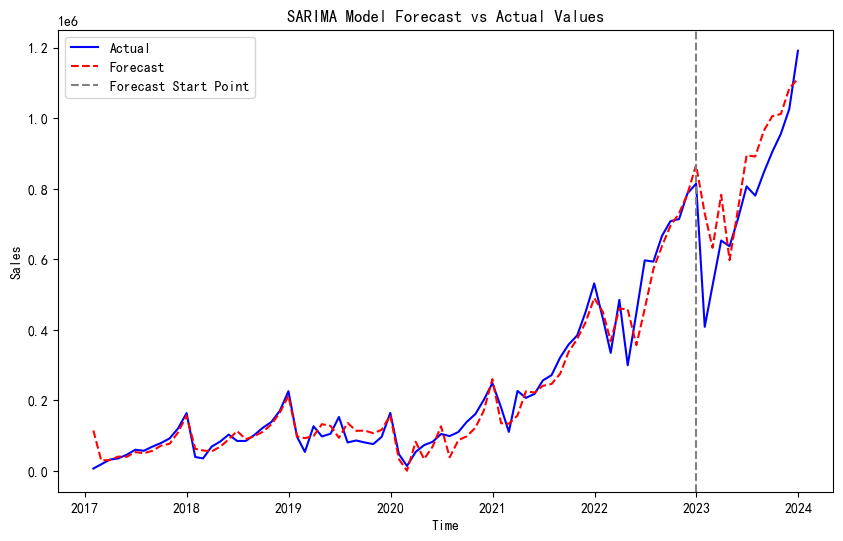

In [18]:
# Predict future values
forecast = ma.predict(12, 95)

# Construct a DataFrame containing both historical and forecasted data
forecast_df_all = pd.DataFrame({
    'Actual': df_nev_sale.loc['2017-01-01':'2023-12-31', 'nev_sale'],  # Extract actual values from the original data
    'Forecast': forecast
})

# Plot actual values and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(forecast_df_all['Actual'], label='Actual', color='blue')
plt.plot(forecast_df_all['Forecast'], label='Forecast', color='red', linestyle='--')
plt.axvline(x=pd.to_datetime('2023-01-01'), color='grey', linestyle='--', label='Forecast Start Point')
plt.title('SARIMA Model Forecast vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()
